In [77]:
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.util import ngrams
import joblib
import re 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns  # Import de Seaborn
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer





In [78]:
import pandas as pd

In [79]:
#import pandas as pd

# chargement du fichier csv

data_politics= pd.read_csv('/Users/benothmane/Desktop/politics_news2.csv')
data_politics.head(10)



,title,text,subject,date,label
0,ABOUT HILLARY’S COUGH: We Discovered The Secre...,,politics,"Jul 20, 2016",Fake
1,BREAKING: OBAMACARE REPEAL Clears First Hurdle...,The Senate voted 51-48 this afternoon to proce...,politics,"Jan 4, 2017",Fake
2,‘SLEEPY’ JUSTICE GINSBURG: Excites Crowd By Sa...,So much for the SCOTUS not being political Che...,left-news,"Feb 7, 2017",Fake
3,WATCH: Kellyanne Conway Very Upset Hillary Cl...,White House counselor Kellyanne Conway crawled...,News,"August 24, 2017",Fake
4,"GOP Gives Trump The Middle Finger, Prepares T...",Donald Trump may have decided that Russia is g...,News,"December 9, 2016",Fake
5,Trump Displays Incredible Ignorance Yet Again...,Have you ever wondered where a phrase started?...,News,"May 11, 2017",Fake
6,Anthony Bourdain Reveals The ‘ONE Good Thing’...,While Donald Trump is currently freaking out b...,News,"December 22, 2016",Fake
7,TRUMP HITS BACK After Cowgirl Congresswoman Tr...,The left is going ballistic over supposed word...,left-news,"Oct 18, 2017",Fake
8,MEDIA DOWNPLAYS Attack By Unhinged Neighbor On...,"5 broken ribs with trouble breathing, lung con...",politics,"Nov 6, 2017",Fake
9,Why This Attorney General Is Going After Trum...,New York Attorney General Eric Schneiderman is...,News,"May 31, 2016",Fake


TRAITEMENT DU DATASET

In [80]:
#dimension du dataset
print(data_politics.shape)

(5000, 5)


In [81]:
#verification de valeurs nules
data_politics['text'].isnull()
data_politics['label'].isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
4995    False
4996    False
4997    False
4998    False
4999    False
Name: label, Length: 5000, dtype: bool

In [82]:
#nombre de colonnes du dataset
list(data_politics.columns)



['title', 'text', 'subject', 'date', 'label']

In [83]:
# Gérer les valeurs manquantes
data_politics = data_politics.dropna
# Vérifier les valeurs uniques avant nettoyage
print("Valeurs uniques dans la colonne 'label' avant nettoyage :")
print(data_politics['label'].unique())


Valeurs uniques dans la colonne 'label' avant nettoyage :


TypeError: 'method' object is not subscriptable

In [74]:
# les valeurs manquantes dans chaque colonne
missing_values = data_politics.isnull().sum()
# le nombre de valeurs manquantes par colonne
print("Nombre de valeurs manquantes par colonne :")
print(missing_values)

Nombre de valeurs manquantes par colonne :
title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [60]:
#descriptifs du dataset
summary = data_politics.text.str.split().str.len()
summary.describe()

count    5000.000000
mean      410.028800
std       394.526883
min         0.000000
25%       213.000000
50%       358.000000
75%       506.000000
max      8135.000000
Name: text, dtype: float64

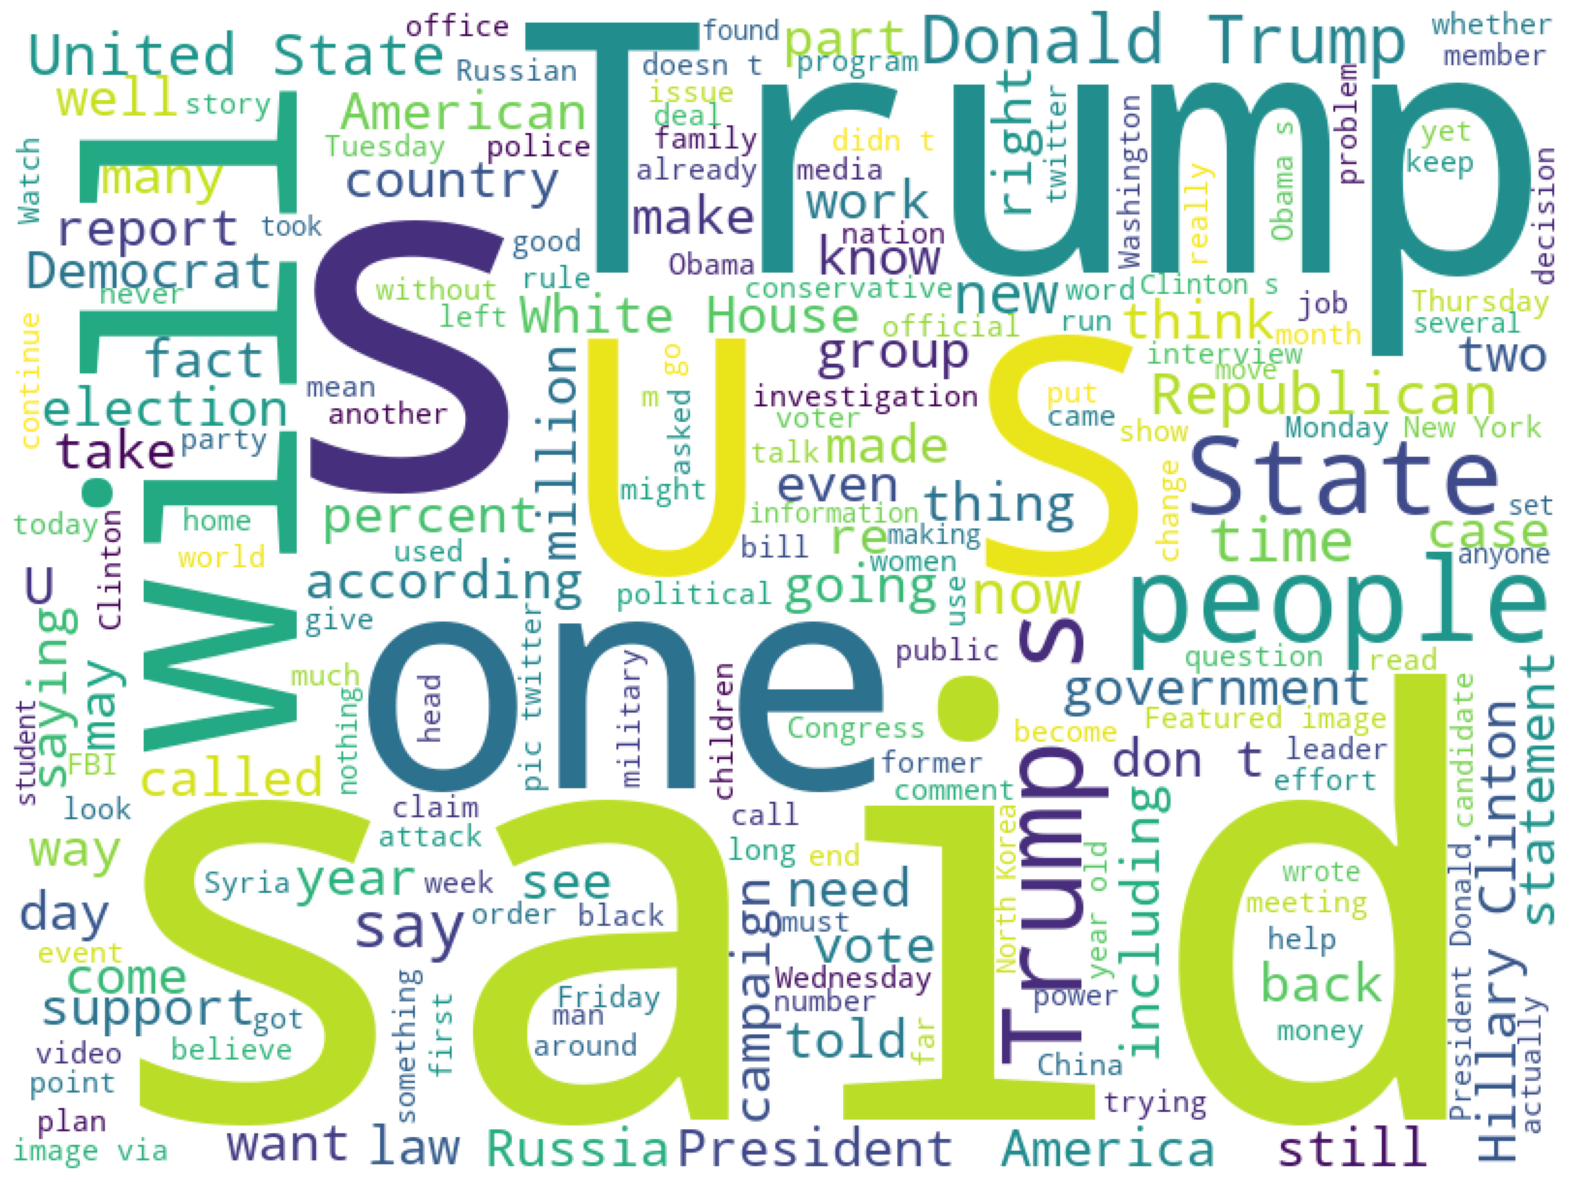

In [63]:
###implementation du word cloud
# Conversion  des données de la colonne "text" en chaînes de caractères
data_politics['text'] = data_politics['text'].astype(str)

wordcloud = WordCloud( background_color='white', width=800, height=600)

text_cloud = wordcloud.generate(''.join(data_politics['text']))
# plot de word cloud
plt.figure(figsize=(20,30))
plt.imshow(text_cloud)
plt.axis('off')
plt.show()

In [67]:
# Dataset 'text' et 'label' for the labels
real_news = data_politics[data_politics['label'] == 'Real']['text']


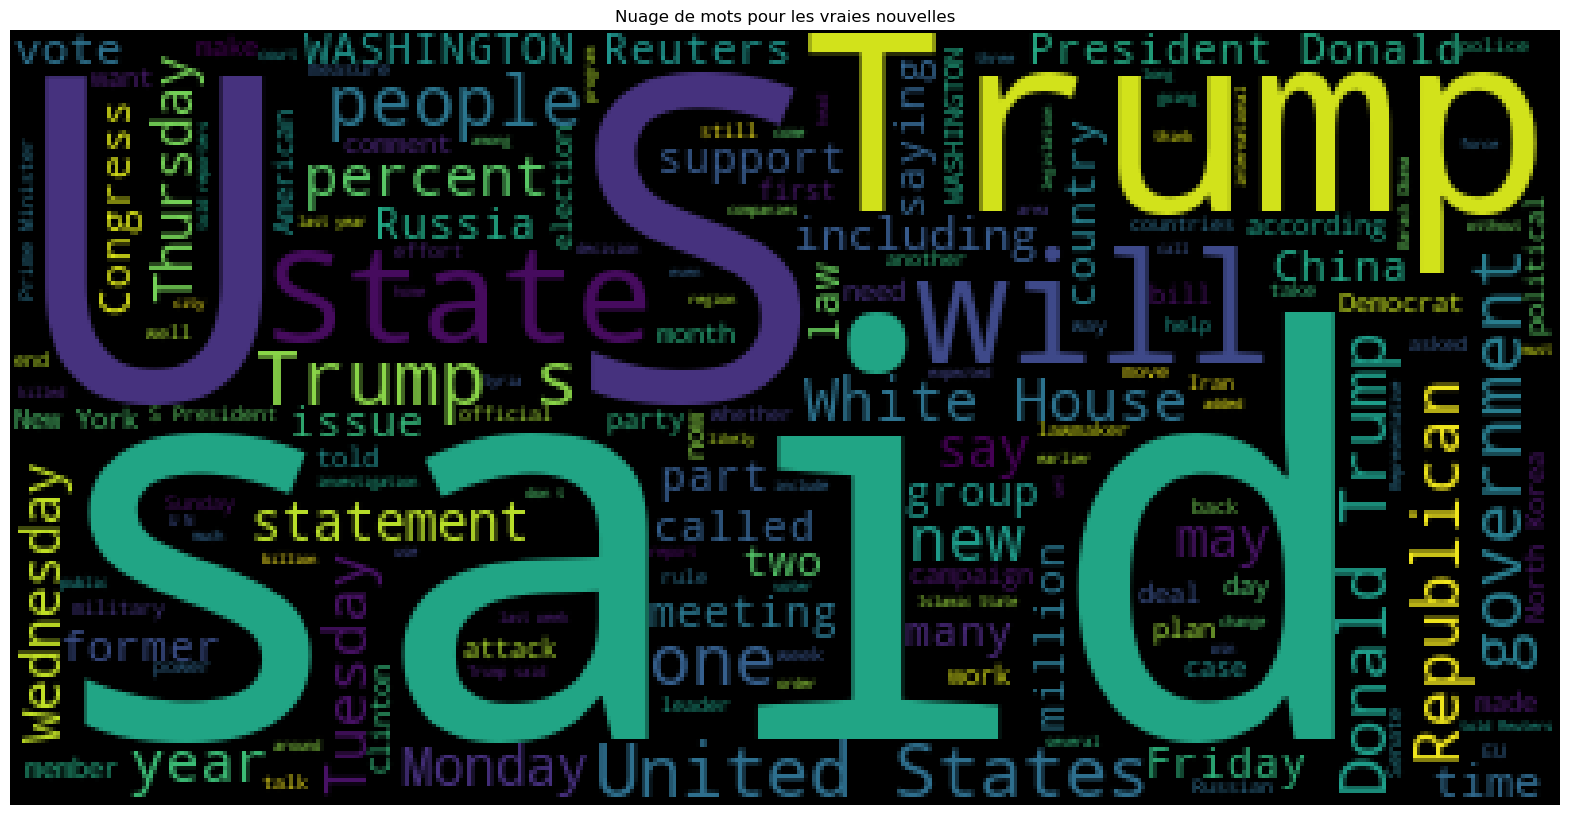

In [68]:

# Pour les vraies NEWS
if not real_news.empty:
    
    # nuage de mots
    wc_real_news = WordCloud().generate(' '.join(real_news))

    # Affichage de nuage de mots
    plt.figure(figsize=(20, 30))
    plt.imshow(wc_real_news)
    plt.axis('off')
    plt.title('Nuage de mots pour les vraies nouvelles')
    plt.show()
else:
    print("Aucune vraie nouvelle trouvée.")

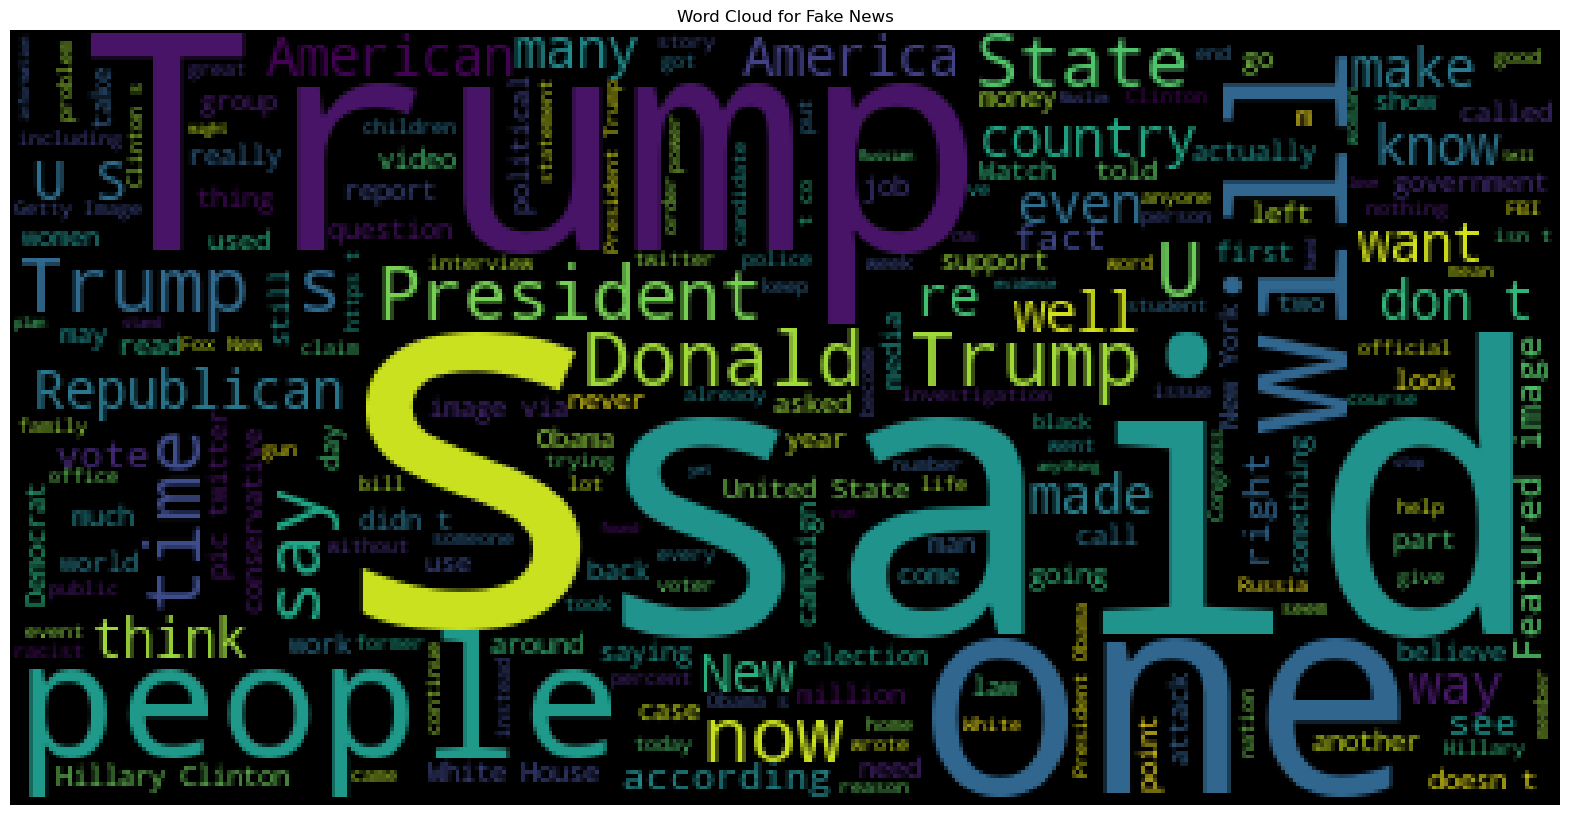

In [69]:
# Pour les fausse news
# Extraire les fausses nouvelles de l'ensemble de données
fake_news = data_politics[data_politics['label'] == 'Fake']['text']

# Vérification des fausses nouvelles 
if not fake_news.empty:
    # nuage de mots
    wc_fake_news = WordCloud().generate(' '.join(fake_news))

    # Affichage du nuage de mots
    plt.figure(figsize=(20, 30))
    plt.imshow(wc_fake_news)
    plt.axis('off')
    plt.title('Word Cloud for Fake News')
    plt.show()
else:
    print("No fake news found.")

Distribution de labels:
label
Fake    3250
Real    1750
Name: count, dtype: int64


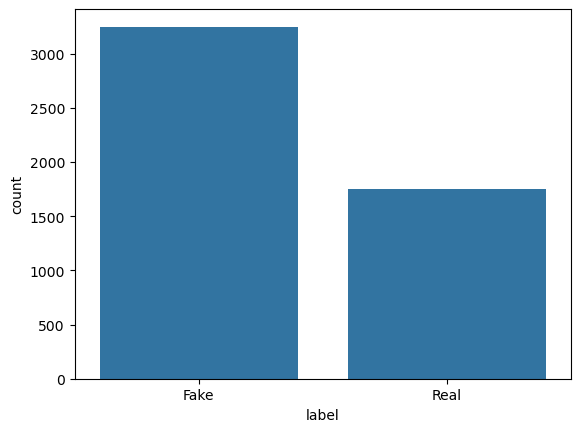

In [70]:

#Distribution de labels Fake et Real
sns.countplot(x="label", data=data_politics);
print("Distribution de labels:")
print(data_politics.label.value_counts());

In [71]:
#affiche de la propotion entre REAL et FAKE
print(round(data_politics.label.value_counts(normalize=True),2)*100);


label
Fake    65.0
Real    35.0
Name: proportion, dtype: float64


In [22]:
#nettoyage du dataset
import re
def remove_symbols_from_dataset(dataset, symbols):
    
    dataset_cleaned = dataset.copy()  # Copier le dataset pour éviter de modifier l'original
    
    # Suppression des  symboles spécifiés de chaque valeur de chaîne de caractères dans le dataset
    for column in dataset_cleaned.columns:
        if dataset_cleaned[column].dtype == 'object':  
            dataset_cleaned[column] = dataset_cleaned[column].str.replace('|'.join(map(re.escape, symbols)), '')
    
    return dataset_cleaned

# Liste des symboles à supprimer
symbols_to_remove = [' """"""" ', '@']

# fonction pour supprimer les symboles du dataset data_politics
data_politics_cleaned = remove_symbols_from_dataset(data_politics, symbols_to_remove)

Text(0.5, 1.0, 'Top 30 Trigram Frequencies of Real News')

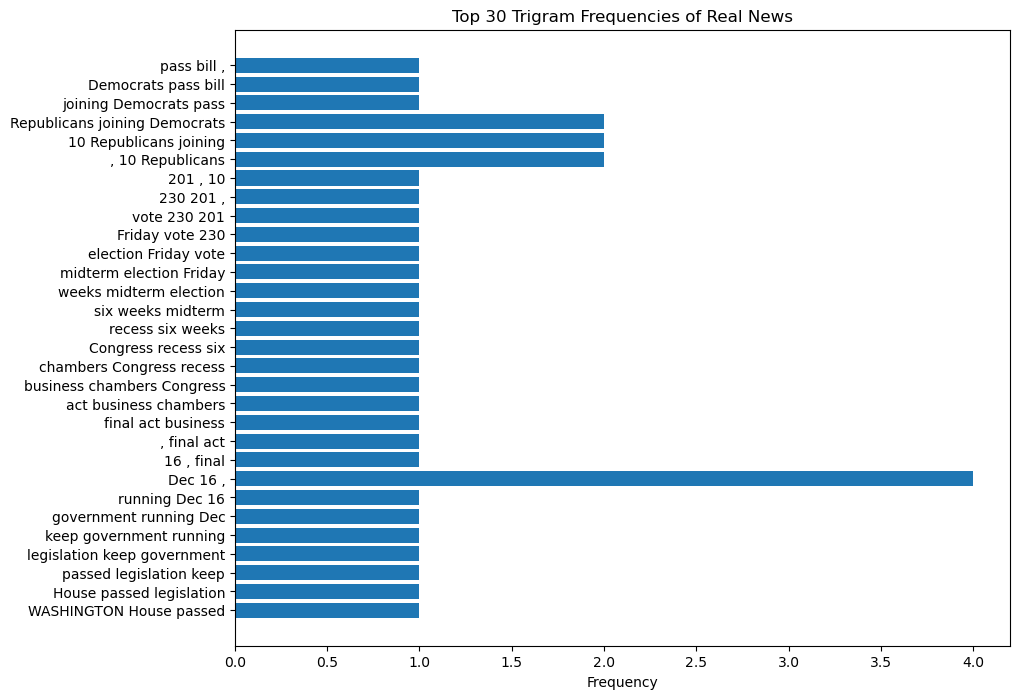

In [25]:

#Affichage de trigrame identifiés comme REAL
# fichier csv
df = pd.read_csv('/Users/benothmane/Desktop/Politics_news2.csv')

# Filtrage des données pour obtenir uniquement celles avec le label 'Real'
real_news_df = data_politics[data_politics['label'] == 'REAL']  # Assurez-vous que 'Label' est le nom de la colonne contenant les labels


text_data = ' '.join(real_news_df['text'].dropna().astype(str))

# les trigrammes
trigrams = ngrams(text_data.split(), 3)

# fréquence des trigrammes
trigram_freq = Counter(trigrams)

# Formatage des trigrammes pour l'affichage
formatted_trigrams = [' '.join(trigram) for trigram in trigram_freq.keys()]

# histogramme renversé
plt.figure(figsize=(10, 8))
plt.barh(formatted_trigrams[:30], list(trigram_freq.values())[:30])  # Afficher les 30 trigrammes les plus fréquents
plt.xlabel('Frequency')
plt.title('Top 30 Trigram Frequencies of Real News')






Text(0.5, 1.0, 'Top 30 Trigram Frequencies of fake News')

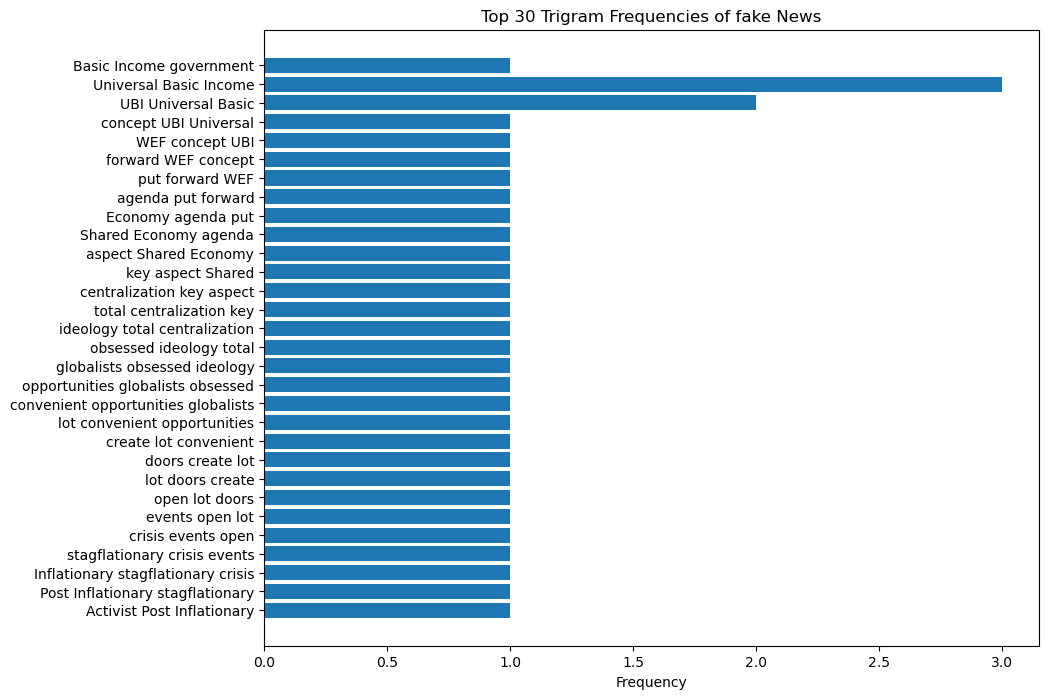

In [27]:
#  fichier csv
df = pd.read_csv('/Users/benothmane/Desktop/Politics_news_datset.csv')

# Filtrage des données pour obtenir uniquement celles avec le label 'Real'
real_news_df = data_politics[data_politics['label'] == 'FAKE']  # Assurez-vous que 'Label' est le nom de la colonne contenant les labels


text_data = ' '.join(real_news_df['text'].dropna().astype(str))

#  trigrammes
trigrams = ngrams(text_data.split(), 3)

# fréquence des trigrammes
trigram_freq = Counter(trigrams)

# Formatage des trigrammes pour l'affichage
formatted_trigrams = [' '.join(trigram) for trigram in trigram_freq.keys()]

# histogramme renversé
plt.figure(figsize=(10, 8))
plt.barh(formatted_trigrams[:30], list(trigram_freq.values())[:30])  # Afficher les 30 trigrammes les plus fréquents
plt.xlabel('Frequency')
plt.title('Top 30 Trigram Frequencies of fake News')



Pretraitement de dataset


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import joblib


# Division des données en caractéristiques (texte) et étiquettes (labels)
X = data_politics['text']
y = data_politics['label']

# Vectorisation du texte
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

In [29]:
# Séparation des données données en ensembles d'entraînement et de test
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.05, random_state=42)


In [32]:
#dimensions dataset train
xtrain.shape

(4845, 46367)

In [33]:
#dimensions dataset test
xtest.shape

(255, 46367)

In [34]:
# Création  et entraînement du  modèle de détection de fausses nouvelles en utilisant logistic regression
model = LogisticRegression()
model.fit(xtrain, ytrain)

LogisticRegression()

In [35]:
# Évaluation du modèle
y_pred = model.predict(xtest)
accuracy = accuracy_score(ytest, y_pred)
report = classification_report(ytest, y_pred)
print("Précision du modèle:", accuracy)
print("Rapport de classification :\n", report)

Précision du modèle: 0.788235294117647
Rapport de classification :
               precision    recall  f1-score   support

        FAKE       0.81      0.77      0.79       132
        REAL       0.76      0.81      0.79       123

    accuracy                           0.79       255
   macro avg       0.79      0.79      0.79       255
weighted avg       0.79      0.79      0.79       255



In [37]:
# Création des DataFrames pour les ensembles d'entraînement et de test
train_df = pd.DataFrame(data=xtrain.toarray(), columns=vectorizer.get_feature_names_out())
train_df['label'] = ytrain

test_df = pd.DataFrame(data=xtest.toarray(), columns=vectorizer.get_feature_names_out())
test_df['label'] = ytest

# Sauvegarde du modèle et du vectorizer
modele_path = '/Users/benothmane/Desktop/Projet IA/modele_logistic_regression.pkl'
vectorizer_path = '/Users/benothmane/Desktop/Projet IA/vectorizer.pkl'

joblib.dump(model, modele_path)
joblib.dump(vectorizer, vectorizer_path)

print("Modèle et vectorizer sauvegardés avec succès.")

Modèle et vectorizer sauvegardés avec succès.


In [36]:
# prédictions sur les 100 premières lignes de l'ensemble de test
predictions = model.predict(xtest[:100])

# Affichage des prédictions
print("Prédictions sur les 100 premières lignes de l'ensemble de test :")
print(predictions)

Prédictions sur les 100 premières lignes de l'ensemble de test :
['REAL' 'FAKE' 'REAL' 'REAL' 'FAKE' 'REAL' 'REAL' 'FAKE' 'FAKE' 'REAL'
 'FAKE' 'REAL' 'FAKE' 'FAKE' 'FAKE' 'REAL' 'FAKE' 'FAKE' 'REAL' 'FAKE'
 'FAKE' 'FAKE' 'FAKE' 'REAL' 'FAKE' 'REAL' 'REAL' 'FAKE' 'FAKE' 'REAL'
 'FAKE' 'FAKE' 'FAKE' 'FAKE' 'REAL' 'FAKE' 'FAKE' 'FAKE' 'FAKE' 'REAL'
 'FAKE' 'REAL' 'FAKE' 'REAL' 'REAL' 'REAL' 'REAL' 'FAKE' 'REAL' 'REAL'
 'FAKE' 'FAKE' 'FAKE' 'FAKE' 'REAL' 'FAKE' 'FAKE' 'REAL' 'REAL' 'REAL'
 'REAL' 'FAKE' 'FAKE' 'REAL' 'REAL' 'REAL' 'REAL' 'FAKE' 'FAKE' 'FAKE'
 'FAKE' 'REAL' 'FAKE' 'REAL' 'REAL' 'FAKE' 'FAKE' 'REAL' 'FAKE' 'FAKE'
 'REAL' 'FAKE' 'FAKE' 'REAL' 'REAL' 'REAL' 'FAKE' 'REAL' 'FAKE' 'FAKE'
 'FAKE' 'FAKE' 'REAL' 'REAL' 'REAL' 'FAKE' 'REAL' 'FAKE' 'FAKE' 'REAL']


In [39]:
#modele de naive bayes
from sklearn.naive_bayes import MultinomialNB
# Division des données en caractéristiques (texte) et étiquettes (labels)
X = data_politics['text']
y = data_politics['label']

# Vectorisation du texte
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(X)

# Séparation des données en ensembles d'entraînement et de test
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.05, random_state=42, stratify=y)

# Entraînement du modèle (Naive Bayes)
model = MultinomialNB()
model.fit(xtrain, ytrain)

# Évaluation du modèle
y_pred = model.predict(xtest)
accuracy = accuracy_score(ytest, y_pred)
report = classification_report(ytest, y_pred)

# Création des DataFrames pour les ensembles d'entraînement et de test
train_df = pd.DataFrame(data=xtrain.toarray(), columns=vectorizer.get_feature_names_out())
train_df['label'] = ytrain

test_df = pd.DataFrame(data=xtest.toarray(), columns=vectorizer.get_feature_names_out())
test_df['label'] = ytest

# Sauvegarde du modèle et du vectorizer
modele_path = '/Users/benothmane/Desktop/Projet IA/modele_naive_bayes.pkl'
vectorizer_path = '/Users/benothmane/Desktop/Projet IA/vectorizer.pkl'

joblib.dump(model, modele_path)
joblib.dump(vectorizer, vectorizer_path)

# Résultats
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.7294117647058823
Classification Report:
              precision    recall  f1-score   support

        FAKE       0.72      0.76      0.74       127
        REAL       0.74      0.70      0.72       128

    accuracy                           0.73       255
   macro avg       0.73      0.73      0.73       255
weighted avg       0.73      0.73      0.73       255



In [43]:

# Chargement du modèle et du vectorizer
model = joblib.load('/Users/benothmane/Desktop/Projet IA/modele_logistic_regression.pkl')
vectorizer = joblib.load('/Users/benothmane/Desktop/Projet IA/vectorizer.pkl')

# Définition de la fonction de prédiction
def predict_news(text):
    # Vectorisation du texte
    text_vectorized = vectorizer.transform([text])
    
    # Prédiction avec le modèle
    prediction = model.predict(text_vectorized)
    
    # Affichage du résultat
    if prediction == 'REAL':
        print("Real News")
        
    else:
        print("Fake News.")

# Input du texte de la news
text_to_predict = input("entrez un titre")

# Faire la prédiction
predict_news(text_to_predict)

entrez un titre /Users/benothmane/Desktop/politics_News.csv


ValueError: X has 5000 features, but LogisticRegression is expecting 46367 features as input.

In [ ]:
#lien du de la source ou a ete extrait le texte
#https://www.theguardian.com/uk-news/article/2024/may/14/home-office-department-processing-rwanda-deportations-told-to-cut-jobs